### Name : Asma Massad

# Assignment 1 - Spam Classification

**<font color="#FF0000" size=4> In this Assignment we will explore and experiment with several classification and predictive models (KNN, SVM, Decision tree and Naïve Bayesian) to differentiate between spam and ham text messages. </font>**



In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, f1_score

import string

%matplotlib inline  

### Data Loading

In [2]:
df = pd.read_csv('data/SMSSpamCollection.txt', sep = '\t', header=None, names=["sms_label", "sms_text"])
df.head()

,sms_label,sms_text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.shape

(5572, 2)

In [4]:
df.isnull().sum()

sms_label    0
sms_text     0
dtype: int64

### Data Preprocessing and Feature Engineering

In [5]:
df['sms_label'].value_counts()

ham     4825
spam     747
Name: sms_label, dtype: int64

<AxesSubplot:title={'center':'Spam-Ham Percentages'}, ylabel='sms_label'>

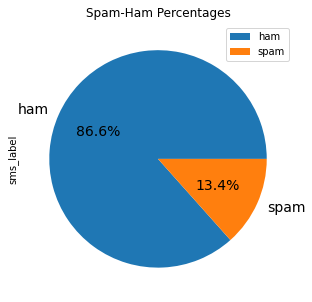

In [6]:
label = df['sms_label'].value_counts()
label.plot.pie(figsize=(5, 5),title='Spam-Ham Percentages',
                             fontsize=14, 
                             legend=True, 
                             autopct=lambda v: "{:0.1f}%".format(v))

### Adding  sms_length column to the dataFrame

In [7]:
df['sms_length'] = df['sms_text'].str.split().str.len()
df.head(3)

,sms_label,sms_text,sms_length
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28


**<font color="#FF0000" size=3> Now we need to clean the text by converting any upper case character into lower case form, and then removing stopwords and punctuation marks. Finally we can create a bag of words containing all the unique words in the dataset, and consider each word as a feature. </font>**

#### Convert to lower case

In [8]:

df['sms_text']= df['sms_text'].str.lower()
df.head(3)

,sms_label,sms_text,sms_length
0,ham,"go until jurong point, crazy.. available only ...",20
1,ham,ok lar... joking wif u oni...,6
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28


In [9]:
stopWords = stopwords.words('english')
punctuation = string.punctuation

#### Remove stopwords & punctuation

In [10]:
df['no_stopwords'] = df['sms_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWords)]))
df.head()

,sms_label,sms_text,sms_length,no_stopwords
0,ham,"go until jurong point, crazy.. available only ...",20,"go jurong point, crazy.. available bugis n gre..."
1,ham,ok lar... joking wif u oni...,6,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say so early hor... u c already then say...,11,u dun say early hor... u c already say...
4,ham,"nah i don't think he goes to usf, he lives aro...",13,"nah think goes usf, lives around though"


In [11]:
# A function for removing the punctuation
def remove_punctuations(st):
    for punctuation in string.punctuation:
        st = st.replace(punctuation, '')
    return st
# Apply to the DF series
df['no_punctuation'] = df['no_stopwords'].apply(remove_punctuations)
df.head(3)

,sms_label,sms_text,sms_length,no_stopwords,no_punctuation
0,ham,"go until jurong point, crazy.. available only ...",20,"go jurong point, crazy.. available bugis n gre...",go jurong point crazy available bugis n great ...
1,ham,ok lar... joking wif u oni...,6,ok lar... joking wif u oni...,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...,free entry 2 wkly comp win fa cup final tkts 2...


**<font color="#FF0000" size=3> We will create a vector of all the unique words in the dataset </font>**

In [12]:
df['sms_words'] = df["no_punctuation"].apply(lambda x: str(x).split(' '))
df.head(3)

,sms_label,sms_text,sms_length,no_stopwords,no_punctuation,sms_words
0,ham,"go until jurong point, crazy.. available only ...",20,"go jurong point, crazy.. available bugis n gre...",go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,ok lar... joking wif u oni...,6,ok lar... joking wif u oni...,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,free entry 2 wkly comp win fa cup final tkts 2...,free entry 2 wkly comp win fa cup final tkts 2...,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."


In [13]:
bag_of_words = set(df['sms_words'].sum())


In [14]:
print(len(bag_of_words))

9625


**<font color=#ff00000 size=4>To create features from the unique words TF-IDF Vectorizer from scikit-learn library will be used </font>**

**<font size=3>TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.</font>**

In [15]:
tfidf=TfidfVectorizer()
features=tfidf.fit_transform(df['no_punctuation']).todense()

In [16]:
vectorDF=pd.DataFrame(features,columns=tfidf.get_feature_names_out())
vectorDF.shape

(5572, 9511)

In [17]:
vectorDF['sms_length'] = df['sms_length']  
encoder=LabelEncoder()
vectorDF['sms_label']=encoder.fit_transform(df['sms_label'])


In [18]:
vectorDF.head(3)

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,...,zindgi,zoe,zogtorius,zoom,zouk,zyada,üll,〨ud,sms_length,sms_label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,1


## Building Classification Models

**<font color=#FF0000 size=3> Creating a train and test sets </font>**

In [19]:
labelDF = vectorDF['sms_label']
featuresDF = vectorDF.drop('sms_label',axis=1)
trainX, testX, trainY, testY = train_test_split(featuresDF, labelDF,test_size=0.25, random_state=42)

### 1 - Decision Trees

**<font color=#ff0000 size = 3> First we will choose random hyper-parameters, after that we will use GridSearch to find the optimum hyper-parameters. </font>**

In [20]:
tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=10)
tree_clf.fit(trainX, trainY)

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [21]:
tree_predY = tree_clf.predict(testX)
confusion_matrix = confusion_matrix(testY,tree_predY)

In [22]:
confusion_matrix


array([[1196,   11],
       [  40,  146]], dtype=int64)

In [23]:
clf_report = classification_report(testY,tree_predY)
print(clf_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1207
           1       0.93      0.78      0.85       186

    accuracy                           0.96      1393
   macro avg       0.95      0.89      0.92      1393
weighted avg       0.96      0.96      0.96      1393



#### Tuning hyper-parameters using GridSearch

In [22]:
tree_parameters = [{'criterion': ['gini', 'entropy'], 
                     'max_depth': [5,10,15,20]}]


tree_clf2 = GridSearchCV(DecisionTreeClassifier(), tree_parameters,verbose=2)
tree_clf2.fit(trainX, trainY)
    
print("The best parameters are: \n")
print(tree_clf2.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........................criterion=gini, max_depth=5; total time=   1.6s
[CV] END ........................criterion=gini, max_depth=5; total time=   1.4s
[CV] END ........................criterion=gini, max_depth=5; total time=   1.4s
[CV] END ........................criterion=gini, max_depth=5; total time=   1.5s
[CV] END ........................criterion=gini, max_depth=5; total time=   1.4s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.8s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.7s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.7s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.8s
[CV] END .......................criterion=gini, max_depth=10; total time=   1.7s
[CV] END .......................criterion=gini, max_depth=15; total time=   2.3s
[CV] END .......................criterion=gini, m

In [24]:
tree_clf = DecisionTreeClassifier(criterion="gini", max_depth=20)
tree_clf.fit(trainX, trainY)
tree_predY2 = tree_clf.predict(testX)

In [25]:
clf_report = classification_report(testY,tree_predY2)
print(clf_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1207
           1       0.93      0.81      0.87       186

    accuracy                           0.97      1393
   macro avg       0.95      0.90      0.92      1393
weighted avg       0.97      0.97      0.97      1393



In [26]:
tree_probs = tree_clf.predict_proba(testX)
tree_probs = tree_probs[:, 1]
tree_auc = roc_auc_score(testY, tree_probs)
tree_fpr, tree_tpr, _ = roc_curve(testY, tree_probs)
tree_auc

0.8812037309244461

In [27]:
cm = confusion_matrix(y_true=testY, y_pred= tree_predY2)

ax= plt.subplot()
sb.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap='PuRd'); 

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)


TypeError: 'numpy.ndarray' object is not callable

### 2 -  Naive Bayes


**<font color=#ff0000 size = 3> After searching which Naive Bayes algorithm is suited for this task, I found that multinomial Naive Bayes was the most appropriate one. </font>**

In [28]:
# using random alpha at first 
nb_clf = MultinomialNB(alpha=1)
nb_clf.fit(trainX, trainY)


MultinomialNB(alpha=1)

In [29]:
nb_predY = nb_clf.predict(testX)


In [30]:
nb_clf_report = classification_report(testY,nb_predY)
print(nb_clf_report)

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       1.00      0.03      0.05       186

    accuracy                           0.87      1393
   macro avg       0.93      0.51      0.49      1393
weighted avg       0.89      0.87      0.81      1393



#### Tuning hyper-parameters using GridSearch

In [28]:
nb_params = {
  'alpha': [0.001, 0.01, 0.1,1],
  'fit_prior': [True, False],  
}

nb_clf2 = GridSearchCV(MultinomialNB(), nb_params, verbose=2)
nb_clf2.fit(trainX, trainY)
    
print("Best Score: ", nb_clf2.best_score_)
print("Best Params: ", nb_clf2.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ........................alpha=0.001, fit_prior=True; total time=   0.9s
[CV] END ........................alpha=0.001, fit_prior=True; total time=   1.0s
[CV] END ........................alpha=0.001, fit_prior=True; total time=   1.0s
[CV] END ........................alpha=0.001, fit_prior=True; total time=   1.0s
[CV] END ........................alpha=0.001, fit_prior=True; total time=   1.0s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   1.0s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   1.1s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   1.0s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   0.9s
[CV] END .......................alpha=0.001, fit_prior=False; total time=   1.1s
[CV] END .........................alpha=0.01, fit_prior=True; total time=   1.1s
[CV] END .........................alpha=0.01, fit

In [31]:
# using best parameters
nb_clf = MultinomialNB(alpha=0.1, fit_prior = True)
nb_clf.fit(trainX, trainY)

MultinomialNB(alpha=0.1)

In [32]:
nb_predY2 = nb_clf.predict(testX)
nb_clf_report = classification_report(testY,nb_predY2)
print(nb_clf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1207
           1       0.92      0.93      0.92       186

    accuracy                           0.98      1393
   macro avg       0.95      0.96      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [33]:
cm = confusion_matrix(y_true=testY, y_pred=nb_predY2)
ax= plt.subplot()
sb.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap='PuRd'); 

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

TypeError: 'numpy.ndarray' object is not callable

In [34]:
nb_probs = nb_clf.predict_proba(testX)
nb_probs = nb_probs[:, 1]
nb_auc = roc_auc_score(testY, nb_probs)
nb_fpr, nb_tpr, _ = roc_curve(testY, nb_probs)
nb_auc

0.9889622364166021

### 3- K-Nearest Neighbour (KNN)

In [35]:
# Starting with randon k=2
knn_clf = KNeighborsClassifier(n_neighbors = 2) 
knn_clf.fit(trainX,  trainY)


KNeighborsClassifier(n_neighbors=2)

In [36]:
knn_predY = knn_clf.predict(testX)
knn_clf_report = classification_report(testY,knn_predY)
print(knn_clf_report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1207
           1       0.92      0.72      0.80       186

    accuracy                           0.95      1393
   macro avg       0.94      0.85      0.89      1393
weighted avg       0.95      0.95      0.95      1393



In [42]:
knn_params = {
    'n_neighbors': [2,4,6,8,10],
    'leaf_size':[1,2,3,4]
    }

knn_clf2 = GridSearchCV(KNeighborsClassifier(), knn_params, verbose=2)
knn_clf2.fit(trainX, trainY)  

#Print The value of best Hyperparameters
print("Best Params: ", knn_clf2.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END .........................leaf_size=1, n_neighbors=2; total time=   2.0s
[CV] END .........................leaf_size=1, n_neighbors=2; total time=   1.7s
[CV] END .........................leaf_size=1, n_neighbors=2; total time=   1.8s
[CV] END .........................leaf_size=1, n_neighbors=2; total time=   1.8s
[CV] END .........................leaf_size=1, n_neighbors=2; total time=   1.7s
[CV] END .........................leaf_size=1, n_neighbors=4; total time=   1.8s
[CV] END .........................leaf_size=1, n_neighbors=4; total time=   1.8s
[CV] END .........................leaf_size=1, n_neighbors=4; total time=   1.8s
[CV] END .........................leaf_size=1, n_neighbors=4; total time=   1.8s
[CV] END .........................leaf_size=1, n_neighbors=4; total time=   1.7s
[CV] END .........................leaf_size=1, n_neighbors=6; total time=   1.8s
[CV] END .........................leaf_size=1, 

In [37]:
#Using the best Parameters
knn_clf = KNeighborsClassifier(n_neighbors = 4, leaf_size=1) 
knn_clf.fit(trainX,  trainY)

KNeighborsClassifier(leaf_size=1, n_neighbors=4)

In [38]:
knn_predY2 = knn_clf.predict(testX)
knn_clf_report = classification_report(testY,knn_predY2)
print(knn_clf_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1207
           1       0.92      0.93      0.92       186

    accuracy                           0.98      1393
   macro avg       0.95      0.96      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [39]:
cm = confusion_matrix(y_true=testY, y_pred=knn_predY2)

ax= plt.subplot()
sb.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap='PuRd'); 

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

TypeError: 'numpy.ndarray' object is not callable

In [40]:
knn_probs = knn_clf.predict_proba(testX)
knn_probs = knn_probs[:, 1]
knn_auc = roc_auc_score(testY, knn_probs)
knn_fpr, knn_tpr, _ = roc_curve(testY, knn_probs)
knn_auc

0.9257423096453483

### 4 - Support Vector Machine (SVM)

In [41]:
svm_clf = SVC(kernel = 'rbf', C=1, gamma = 0.1)
svm_clf.fit(trainX, trainY)

SVC(C=1, gamma=0.1)

In [42]:
svm_predY = svm_clf.predict(testX)
svm_clf_report = classification_report(testY,svm_predY)
print(svm_clf_report)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1207
           1       1.00      0.56      0.72       186

    accuracy                           0.94      1393
   macro avg       0.97      0.78      0.84      1393
weighted avg       0.94      0.94      0.93      1393



In [45]:
svm_params = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]}
svm_clf2 = GridSearchCV(SVC(),svm_params, verbose=2)
svm_clf2.fit(trainX, trainY)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time= 1.5min
[CV] END .....................................C=0.1, gamma=1; total time= 1.6min
[CV] END .....................................C=0.1, gamma=1; total time= 1.5min
[CV] END .....................................C=0.1, gamma=1; total time= 1.5min
[CV] END .....................................C=0.1, gamma=1; total time= 1.5min
[CV] END ...................................C=0.1, gamma=0.1; total time=  53.8s
[CV] END ...................................C=0.1, gamma=0.1; total time=  57.1s
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.1min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.1min
[CV] END ..................................C=0.1, gamma=0.01; total time=  47.0s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

In [43]:
print("Best parameters: ",svm_clf2.best_estimator_)

NameError: name 'svm_clf2' is not defined

In [44]:
#Using best parameters
svm_clf = SVC(C=100, gamma = 0.01, probability=True)
svm_clf.fit(trainX,  trainY)

SVC(C=100, gamma=0.01, probability=True)

In [45]:
svm_predY2 = svm_clf.predict(testX)
svm_clf_report = classification_report(testY,svm_predY2)
print(svm_clf_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1207
           1       1.00      0.86      0.92       186

    accuracy                           0.98      1393
   macro avg       0.99      0.93      0.96      1393
weighted avg       0.98      0.98      0.98      1393



In [46]:
cm = confusion_matrix(y_true=testY, y_pred=svm_predY2)
cm

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
cm = confusion_matrix(y_true=testY, y_pred=svm_predY2)

ax= plt.subplot()
sb.heatmap(cm, annot=True, ax = ax, fmt = 'g', cmap='PuRd'); 

ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

ax.set_ylabel('Actual', fontsize=20)
ax.yaxis.set_ticklabels(['ham', 'spam'], fontsize = 15)

In [47]:
svm_probs = svm_clf.predict_proba(testX)
svm_probs = svm_probs[:, 1]
svm_auc = roc_auc_score(testY, svm_probs)
svm_fpr, svm_tpr, _ = roc_curve(testY, svm_probs)
svm_auc

0.9908419524102235

## Classifiers ROC 


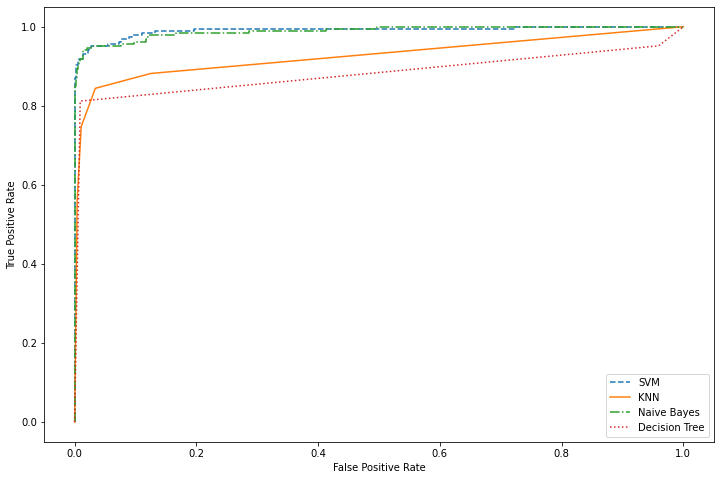

In [48]:
plt.figure(figsize=(12,8))
plt.plot(svm_fpr, svm_tpr, linestyle='--', label='SVM')
plt.plot(knn_fpr, knn_tpr, linestyle='-', label='KNN')
plt.plot(nb_fpr, nb_tpr, linestyle='dashdot', label='Naive Bayes')
plt.plot(tree_fpr, tree_tpr,  linestyle=':', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

## Summary

In [49]:
print("------------- Accuracy -------------")
print("DT:         ",tree_clf.score(testX, testY))
print("Naive Bayes:", nb_clf.score(testX, testY))
print("KNN:        ", knn_clf.score(testX, testY))
print("SVM:        ", svm_clf.score(testX, testY))

------------- Accuracy -------------
DT:          0.9669777458722182
Naive Bayes: 0.9791816223977028
KNN:         0.9569274946159368
SVM:         0.9813352476669059


In [50]:
print("------------- AUC -------------")
print("DT:         ", tree_auc)
print("Naive Bayes:", nb_auc)
print("KNN:        ", knn_auc)
print("SVM:        ", svm_auc)

------------- AUC -------------
DT:          0.8812037309244461
Naive Bayes: 0.9889622364166021
KNN:         0.9257423096453483
SVM:         0.9908419524102235


In [51]:
print("------------- Precision -------------")
print("DT:         ", precision_score(testY, tree_predY2))
print("Naive Bayes:",  precision_score(testY, nb_predY2))
print("KNN:        ",  precision_score(testY, knn_predY2))
print("SVM:        ",  precision_score(testY, svm_predY2))

------------- Precision -------------
DT:          0.9320987654320988
Naive Bayes: 0.9153439153439153
KNN:         0.9153439153439153
SVM:         1.0


In [52]:
print("------------- recall -------------")
print("DT:         ", recall_score(testY, tree_predY2))
print("Naive Bayes:",  recall_score(testY, nb_predY2))
print("KNN:        ",  recall_score(testY, knn_predY2))
print("SVM:        ",  recall_score(testY, svm_predY2))

------------- recall -------------
DT:          0.8118279569892473
Naive Bayes: 0.9301075268817204
KNN:         0.9301075268817204
SVM:         0.8602150537634409


In [53]:
print("------------- F1 Score -------------")
print("DT:         ", f1_score(testY, tree_predY2))
print("Naive Bayes:",  f1_score(testY, nb_predY2))
print("KNN:        ",  f1_score(testY, knn_predY2))
print("SVM:        ",  f1_score(testY, svm_predY2))

------------- F1 Score -------------
DT:          0.867816091954023
Naive Bayes: 0.9226666666666665
KNN:         0.9226666666666665
SVM:         0.9248554913294798


## Conclusion

**<font size=3> When we examin the ROC plot and compare the accracy of each model, it shows that the SVM algorthim was the best classifier for the task with an accuracy of 98.13%, followed by the Naive Bayes, then decision tree and finally the last one was KNN with the lowest accracy of 95.69%. </font>**

**<font size=3>The dataset we used in this assignment is sparse, with a large number of features (high dimensional), also the dataset is imbalanced. This can cause problems for some classifiers. </font>**

**<font size=3> From the results we can conclude that the SVM algorithm is best suited for sparse data. Also SVM is effective in cases where the number of dimensions is greater than the number of samples. </font>**

**<font size=3>The results also go with the known disadvantages of KNN, which is that KNN struggles with large datasets. Also KNN does not perform well with imbalanced data.</font>**